# Exercise 1.1: Markov Chain Monte-Carlo of a single polymer

In [1]:
from pathlib import Path

import scipy.interpolate
import scipy.stats
import numpy as np
import numba
from tqdm.notebook import tqdm as tqdm_
import tqdm.contrib.concurrent
import matplotlib.pyplot as plt

import soft_matter.sample

In [2]:
NUM_SEGMENTS = 16
A_SEGMENTS = 4

np.random.seed(42)  # make experiments reproducible
data_dir = Path.cwd() / ".." / "data"
figure_dir = Path.cwd() / ".." / "report" / "figures"

### Show the fields in the micella

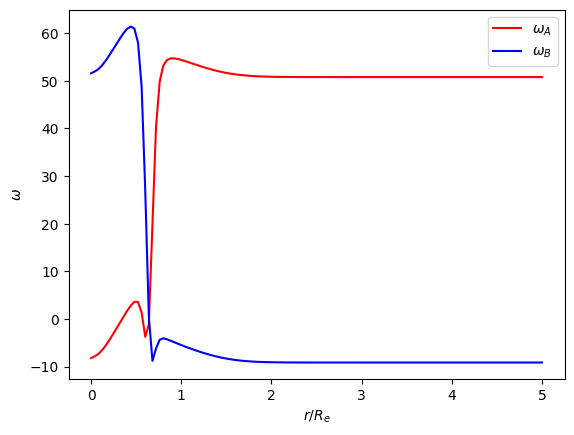

In [3]:
pos, phobic, philic = np.loadtxt(data_dir / "omega.dat", delimiter=" ", skiprows=1, dtype=np.float64).T
field_A = scipy.interpolate.interp1d(pos, phobic, fill_value=phobic[-1], bounds_error=False)
field_B = scipy.interpolate.interp1d(pos, philic, fill_value=philic[-1], bounds_error=False)

r = np.linspace(0, 5, num=1_000)
plt.plot(r, field_A(r), label="$\\omega_A$", color="r")
plt.plot(r, field_B(r), label="$\\omega_B$", color="b")
plt.ylabel("$\\omega$")
plt.xlabel("$r / R_e$")
plt.legend()

In [4]:
SPRING_CONSTANT = 3 * (NUM_SEGMENTS - 1) / 2

@numba.njit
def total_bond_energy(polymer):
    """Calculate the energy of a polymer stored in it's bonds."""
    diffs = polymer[..., 1:, :] - polymer[..., :-1, :]
    summed = np.sum(diffs * diffs)
    return summed * SPRING_CONSTANT

@numba.njit
def polymer_step(polymer):
    """Propose a step on a polymer with a single segment displacement."""
    selected_index = np.random.choice(NUM_SEGMENTS)

    step_length = 1 / np.sqrt(NUM_SEGMENTS - 1)
    uniform_step = np.random.rand(3) * 2 - 1
    displacement = uniform_step * step_length
    
    new_polymer = polymer.copy()
    new_polymer[selected_index, :] += displacement

    return new_polymer

## Simulate without external fields

In [5]:
max_steps = 100_000
drop_start = 10_000
energy = total_bond_energy

old_polymer = soft_matter.sample.sample_initial(NUM_SEGMENTS)
ens = [old_polymer]
energy_old = energy(old_polymer)
for step in tqdm_(range(max_steps * NUM_SEGMENTS)):
    new_polymer = polymer_step(old_polymer)
    energy_new = energy(new_polymer)

    acceptance_rate = np.exp(energy_old - energy_new)
    mc_number = np.random.rand()
    if mc_number < acceptance_rate:  # accepted
        ens.append(new_polymer)
        old_polymer = new_polymer
        energy_old = energy_new
    else:
        ens.append(old_polymer)  # rejected

ens = np.array(ens[drop_start * NUM_SEGMENTS:])

  0%|          | 0/1600000 [00:00<?, ?it/s]

### Analyze the simulation results

x: mean=0.0498 std=0.3192
y: mean=0.0209 std=0.3192
z: mean=0.0535 std=0.3192


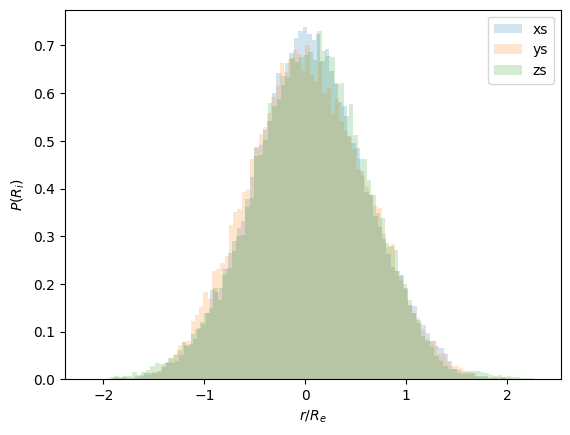

In [6]:
end_to_end = ens[:, 0, :] - ens[:, -1, :]
xs, ys, zs = end_to_end.T
plt.hist(xs, stacked=True, density=True, alpha=.2, bins=100, label="xs")
plt.hist(ys, stacked=True, density=True, alpha=.2, bins=100, label="ys")
plt.hist(zs, stacked=True, density=True, alpha=.2, bins=100, label="zs")
plt.legend()
plt.xlabel("$r/R_e$")
plt.ylabel("$P(R_i)$")
r = np.linspace(-4, 4, num=1000)

print(f"x: mean={xs.mean():.4f} std={xs.var():.4}")
print(f"y: mean={ys.mean():.4f} std={xs.var():.4}")
print(f"z: mean={zs.mean():.4f} std={xs.var():.4}")

In [7]:
@numba.njit
def displacement(pos_ens, delta_t):
    """Calculates displacement from an ensemble of positions."""
    t_all, dims = pos_ens.shape

    r = np.zeros((t_all - delta_t, dims))

    for t in range(t_all - delta_t):
        for dim in range(3):
            r[t, dim] = pos_ens[t + delta_t, dim] - pos_ens[t, dim]
    return r

@numba.njit
def mean_square_displacement(delta_t, pos_ens):
    pos_disp = displacement(pos_ens, delta_t)
    xs, ys, zs = pos_disp.T
    return np.mean(xs*xs + ys*ys + zs*zs)

In [8]:
t_max = int(ens.shape[0] * .1) // 16
delta_ts = range(t_max)

def center_of_mass(polymer_ens):
    """Transform a polymer ensemble to it's COM ensemble."""
    return np.mean(polymer_ens, axis=-2)

com_ens = center_of_mass(ens)
com_auc = tqdm.contrib.concurrent.process_map(mean_square_displacement, delta_ts, (com_ens for _ in delta_ts), chunksize=100)

@numba.njit
def junction_point(polymer_ens):  
    a_last, b_first = ens[:, A_SEGMENTS, :], ens[:, A_SEGMENTS+1, :]
    return (a_last + b_first) / 2

junc_ens = junction_point(ens)
junc_auc = tqdm.contrib.concurrent.process_map(mean_square_displacement, delta_ts, (junc_ens for _ in delta_ts), chunksize=100)

  0%|          | 0/9000 [00:00<?, ?it/s]

  0%|          | 0/9000 [00:00<?, ?it/s]

NameError: name 'auc' is not defined

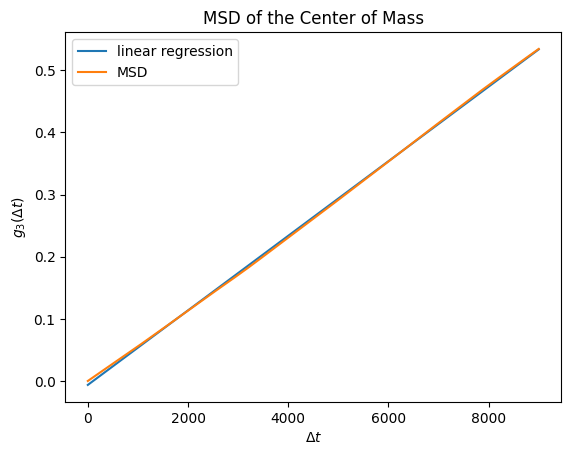

In [9]:
linreg = scipy.stats.linregress(delta_ts, com_auc)
plt.plot(linreg.slope * delta_ts + linreg.intercept, label="linear regression")
plt.plot(com_auc, label="MSD")

plt.title("MSD of the Center of Mass")
plt.xlabel("$\\Delta t$")
plt.ylabel("$g_3(\\Delta t)$")
plt.legend()
plt.savefig(figure_dir / "ex1_com_msd.pdf")

print(f"Self-diffusion coefficient D = {com_auc[-1] / len(com_auc) / 6:.4e}({linreg.slope / 6:.4e})")

In [ ]:
linreg = scipy.stats.linregress(delta_ts, junc_auc)

plt.plot(linreg.slope * delta_ts + linreg.intercept, label="linear regression")

plt.plot(junc_auc, label="Junction Point MSD")

plt.title("MSD of the Junction Point")
plt.xlabel("$\\Delta t$")
plt.ylabel("$g_j(\\Delta t)$")
plt.legend()
plt.savefig(figure_dir / "ex1_junc_msd.pdf")

print(f"Self-diffusion coefficient D = {auc[-1] / len(auc) / 6:.4e}({linreg.slope / 6:.4e})")

In [ ]:
plt.title("Comparison of COM and Junction point MSD")
plt.plot(com_auc, label="COM MSD")
plt.plot(junc_auc, label="Junction MSD")
plt.xlabel("$\\Delta t$")
plt.ylabel("$g_3(\\Delta t)$ or $g_j(\\Delta t)$")
plt.savefig(figure_dir / "ex1_msd_comparison.pdf")

plt.legend()